In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

In [8]:
# load data
users = pd.read_csv('../data/users.csv')
courses = pd.read_csv('../data/courses.csv')
user_reviews = pd.read_csv('../data/users.reviews.csv')

In [9]:
user_reviews.head()

,Unnamed: 0,_class,id,content,rating,created,modified,user_modified,user,course_id,user_id
0,0,course_review,136107616,NaN,5.0,2023-02-19T12:03:53-08:00,2023-02-20T15:05:30-08:00,2023-02-19T12:04:14-08:00,"{""_class"": ""user"", ""title"": ""Bexlcapital"", ""na...",473160,4426
1,1,course_review,136105174,NaN,5.0,2023-02-19T11:07:20-08:00,2023-02-20T15:05:30-08:00,2023-02-19T11:07:21-08:00,"{""_class"": ""user"", ""title"": ""Mr. Irshad"", ""nam...",473160,18314
2,2,course_review,136104456,NaN,5.0,2023-02-19T10:52:58-08:00,2023-02-20T15:05:30-08:00,2023-02-19T10:52:59-08:00,"{""_class"": ""user"", ""title"": ""Victoria Ferrario...",473160,28515
3,3,course_review,136100102,NaN,2.5,2023-02-19T09:29:38-08:00,2023-02-20T15:07:42-08:00,2023-02-19T09:29:42-08:00,"{""_class"": ""user"", ""title"": ""Beeran Ramdhari"",...",473160,4258
4,4,course_review,136099490,NaN,3.0,2023-02-19T09:18:22-08:00,2023-02-20T15:07:42-08:00,2023-02-19T09:18:25-08:00,"{""_class"": ""user"", ""title"": ""Paul Abass Kamara...",473160,20715


In [10]:
# Check number of rows and columns
rows, cols = user_reviews.shape
print('Number of rows: ', rows)
print('Number of columns: ', cols)

Number of rows:  33840
Number of columns:  11


In [11]:
# Check datatype
user_reviews.dtypes

Unnamed: 0         int64
_class            object
id                 int64
content           object
rating           float64
created           object
modified          object
user_modified     object
user              object
course_id          int64
user_id            int64
dtype: object

In [12]:
# Summary statistics of rating
user_reviews['rating'].describe().transpose()

count    33840.000000
mean         4.295464
std          0.958660
min          0.500000
25%          4.000000
50%          4.500000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

In [13]:
#Find the minimum and maximum ratings
print('Minimum rating is: %f' %(user_reviews.rating.min()))
print('Maximum rating is: %f' %(user_reviews.rating.max()))

Minimum rating is: 0.500000
Maximum rating is: 5.000000


In [14]:
# check for missing values
print('Number of missing values across columns: \n', user_reviews.isnull().sum())

Number of missing values across columns: 
 Unnamed: 0           0
_class               0
id                   0
content          26851
rating               0
created              0
modified             0
user_modified        0
user                 0
course_id            0
user_id              0
dtype: int64


# Rating

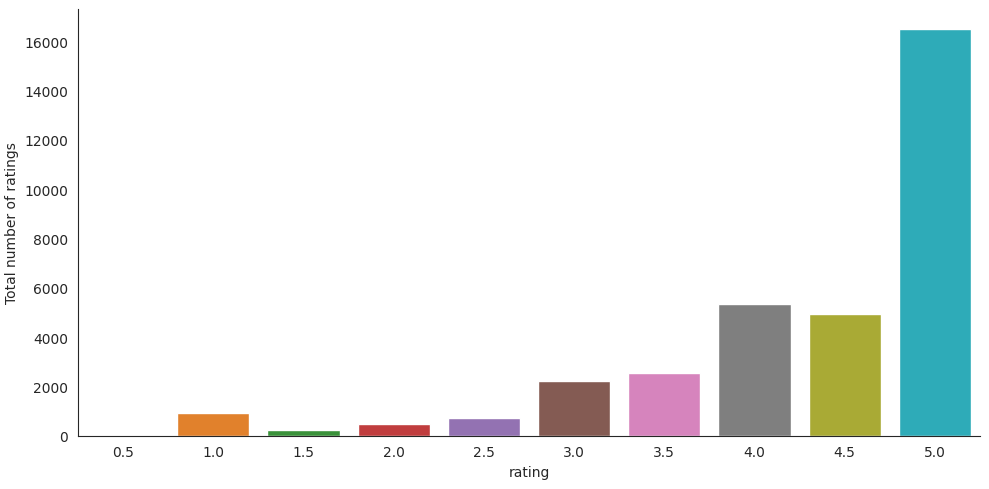

In [19]:
# Check the distribution of rating
with sns.axes_style('white'):
	g = sns.catplot(x="rating", data=user_reviews, aspect=2.0, kind='count')
	g.set_ylabels('Total number of ratings')

In [20]:
# Number of unique user id  in the data
print('Number of unique users in Raw data = ', user_reviews['user_id'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', user_reviews['course_id'].nunique())

Number of unique users in Raw data =  29180
Number of unique product in Raw data =  3754


# Taking the subset of dataset to make it less sparse/denser

In [21]:
# Check top 10 users based on ratings
most_rated = user_reviews.groupby('user_id').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n', most_rated)

Top 10 users based on ratings: 
 user_id
2922     51
5311     30
28763    15
20538    12
16570    11
12654    11
6716     11
7464     10
16544    10
3085      9
dtype: int64


In [23]:
counts=user_reviews.user_id.value_counts()
user_reviews_final=user_reviews[user_reviews.user_id.isin(counts[counts>=15].index)]
print('Number of users who have rated 25 or more items =', len(user_reviews_final))
print('Number of unique users in the final data = ', user_reviews_final['user_id'].nunique())
print('Number of unique products in the final data = ', user_reviews_final['user_id'].nunique())

Number of users who have rated 25 or more items = 96
Number of unique users in the final data =  3
Number of unique products in the final data =  3


In [31]:
# ratings analysis in final dataset
final_rating_matrix = user_reviews_final.pivot_table(index='user_id', columns='course_id', values='rating', aggfunc='mean').fillna(0)
final_rating_matrix.head()

course_id,9711,32939,49798,130064,370098,503406,508112,683926,708254,877482,...,4743758,4801184,4815706,4819256,4911370,4968204,4975632,5026688,5081586,5133914
user_id,,,,,,,,,,,,,,,,,,,,,
2922,0.0,0.0,4.5,0.0,5.0,0.0,2.5,0.0,5.0,0.0,...,5.0,4.5,0.0,0.0,0.0,4.5,3.0,3.0,0.0,0.0
5311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,5.0,0.0,0.0,0.0,4.0,4.0
28763,3.5,4.0,0.0,4.0,0.0,3.5,0.0,4.0,0.0,4.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# Calucating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_rating_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_rating_matrix.shape[0] * final_rating_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  89
possible_num_of_ratings =  267
density: 33.33%


# Split data

In [35]:
#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(user_reviews_final, test_size = 0.3, random_state=0)
train_data.head()

,Unnamed: 0,_class,id,content,rating,created,modified,user_modified,user,course_id,user_id
353,353,course_review,77637194,NaN,3.5,2021-02-12T12:06:17-08:00,2021-02-13T15:07:30-08:00,2021-02-12T12:06:20-08:00,"{""_class"": ""user"", ""title"": ""Anonymized User"",...",1325612,2922
338,338,course_review,72777902,NaN,1.0,2020-12-14T21:47:33-08:00,2020-12-15T15:05:22-08:00,2020-12-14T21:47:34-08:00,"{""_class"": ""user"", ""title"": ""Anonymized User"",...",3668114,2922
357,357,course_review,133722338,NaN,4.5,2023-01-19T23:42:08-08:00,2023-01-20T15:05:41-08:00,2023-01-19T23:42:10-08:00,"{""_class"": ""user"", ""title"": ""Anonymized User"",...",1361324,2922
1257,1257,course_review,135528346,NaN,4.0,2023-02-12T05:48:02-08:00,2023-02-13T15:05:44-08:00,2023-02-12T05:48:03-08:00,"{""_class"": ""user"", ""title"": ""Vishal Bhat"", ""na...",32939,28763
1263,1263,course_review,135528366,NaN,3.5,2023-02-12T05:48:17-08:00,2023-02-13T15:05:44-08:00,2023-02-12T05:48:17-08:00,"{""_class"": ""user"", ""title"": ""Vishal Bhat"", ""na...",2651662,28763


In [36]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (67, 11)
Shape of testing data:  (29, 11)


# Build popularity Recommender model

In [39]:
# Count of user_id for each unique course as recommendation score
train_data_grouped = train_data.groupby('course_id').agg({'user_id': 'count'}).reset_index()
train_data_grouped.rename(columns={'user_id': 'score'}, inplace=True)
train_data_grouped.head(40)

,course_id,score
0,9711,1
1,32939,1
2,130064,1
3,370098,1
4,508112,1
5,683926,1
6,708254,1
7,877482,1
8,887442,2
9,900694,1


In [42]:
# Sort courses on recommendation score
train_data_sort = train_data_grouped.sort_values(['score', 'course_id'], ascending=[0, 1])

# Generate a recommendation rank based on score
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first')

# Get the top 5 recommendatios
popularity_recommendations = train_data_sort.head(5)
popularity_recommendations

,course_id,score,rank
8,887442,2,1.0
17,1329914,2,2.0
0,9711,1,3.0
1,32939,1,4.0
2,130064,1,5.0


In [48]:
# Use popularity based recommender model to make predictions
def recommend(user_id):
	user_recommendations = popularity_recommendations
	
	# Add user_id column for which the recommendations are being generated
	user_recommendations['user_id'] = user_id
 
	# Bring user_id column to the front
	cols = user_recommendations.columns.tolist()
	cols = cols[-1:] + cols[:-1]
	user_recommendations = user_recommendations[cols]
	return user_recommendations

In [49]:
find_recom = [10, 100, 150] # list of user_id
for i in find_recom:
	print(f'The list of recommendations for the user_id {i}')
	print(recommend(i))
	print('\n**\n')

The list of recommendations for the user_id 10
    user_id  course_id  score  rank
8        10     887442      2   1.0
17       10    1329914      2   2.0
0        10       9711      1   3.0
1        10      32939      1   4.0
2        10     130064      1   5.0

**

The list of recommendations for the user_id 100
    user_id  course_id  score  rank
8       100     887442      2   1.0
17      100    1329914      2   2.0
0       100       9711      1   3.0
1       100      32939      1   4.0
2       100     130064      1   5.0

**

The list of recommendations for the user_id 150
    user_id  course_id  score  rank
8       150     887442      2   1.0
17      150    1329914      2   2.0
0       150       9711      1   3.0
1       150      32939      1   4.0
2       150     130064      1   5.0

**



C:\Users\PC\AppData\Local\Temp\ipykernel_33376\571282288.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_recommendations['user_id'] = user_id
C:\Users\PC\AppData\Local\Temp\ipykernel_33376\571282288.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_recommendations['user_id'] = user_id
C:\Users\PC\AppData\Local\Temp\ipykernel_33376\571282288.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

# Build collaborative filtering recommender model

In [52]:
courses_df_CF = pd.concat([train_data, test_data]).reset_index()
courses_df_CF.drop(['Unnamed: 0'], axis=1, inplace=True)
courses_df_CF.head()

,index,_class,id,content,rating,created,modified,user_modified,user,course_id,user_id
0,353,course_review,77637194,NaN,3.5,2021-02-12T12:06:17-08:00,2021-02-13T15:07:30-08:00,2021-02-12T12:06:20-08:00,"{""_class"": ""user"", ""title"": ""Anonymized User"",...",1325612,2922
1,338,course_review,72777902,NaN,1.0,2020-12-14T21:47:33-08:00,2020-12-15T15:05:22-08:00,2020-12-14T21:47:34-08:00,"{""_class"": ""user"", ""title"": ""Anonymized User"",...",3668114,2922
2,357,course_review,133722338,NaN,4.5,2023-01-19T23:42:08-08:00,2023-01-20T15:05:41-08:00,2023-01-19T23:42:10-08:00,"{""_class"": ""user"", ""title"": ""Anonymized User"",...",1361324,2922
3,1257,course_review,135528346,NaN,4.0,2023-02-12T05:48:02-08:00,2023-02-13T15:05:44-08:00,2023-02-12T05:48:03-08:00,"{""_class"": ""user"", ""title"": ""Vishal Bhat"", ""na...",32939,28763
4,1263,course_review,135528366,NaN,3.5,2023-02-12T05:48:17-08:00,2023-02-13T15:05:44-08:00,2023-02-12T05:48:17-08:00,"{""_class"": ""user"", ""title"": ""Vishal Bhat"", ""na...",2651662,28763


In [70]:
# Matrix with row per 'user' and column per 'item'
pivot_df = courses_df_CF.pivot_table(index='user_id', columns='course_id', values='rating', aggfunc='mean').fillna(0)
pivot_df.head()

course_id,9711,32939,49798,130064,370098,503406,508112,683926,708254,877482,...,4743758,4801184,4815706,4819256,4911370,4968204,4975632,5026688,5081586,5133914
user_id,,,,,,,,,,,,,,,,,,,,,
2922,0.0,0.0,4.5,0.0,5.0,0.0,2.5,0.0,5.0,0.0,...,5.0,4.5,0.0,0.0,0.0,4.5,3.0,3.0,0.0,0.0
5311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,5.0,0.0,0.0,0.0,4.0,4.0
28763,3.5,4.0,0.0,4.0,0.0,3.5,0.0,4.0,0.0,4.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
print('Shape of the table: ', pivot_df.shape)

Shape of the table:  (3, 89)


In [72]:
# Define user index from 0 to 2
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

course_id,9711,32939,49798,130064,370098,503406,508112,683926,708254,877482,...,4801184,4815706,4819256,4911370,4968204,4975632,5026688,5081586,5133914,user_index
user_id,,,,,,,,,,,,,,,,,,,,,
2922,0.0,0.0,4.5,0.0,5.0,0.0,2.5,0.0,5.0,0.0,...,4.5,0.0,0.0,0.0,4.5,3.0,3.0,0.0,0.0,0
5311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,5.0,0.0,0.0,0.0,4.0,4.0,1
28763,3.5,4.0,0.0,4.0,0.0,3.5,0.0,4.0,0.0,4.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [73]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

course_id,9711,32939,49798,130064,370098,503406,508112,683926,708254,877482,...,4743758,4801184,4815706,4819256,4911370,4968204,4975632,5026688,5081586,5133914
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,4.5,0.0,5.0,0.0,2.5,0.0,5.0,0.0,...,5.0,4.5,0.0,0.0,0.0,4.5,3.0,3.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,5.0,0.0,0.0,0.0,4.0,4.0
2,3.5,4.0,0.0,4.0,0.0,3.5,0.0,4.0,0.0,4.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
# Singular value Decomposition
U, sigma, Vt = svds(pivot_df.to_numpy(), k = 2)
print('Left singular matrix: \n', U)

Left singular matrix: 
 [[ 0.00000000e+00 -1.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00]
 [-2.08166817e-17 -3.08148791e-33]]


In [82]:
print('Sigma: \n', sigma)

Sigma: 
 [23.8117618  28.84874347]


In [83]:
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n', sigma)

Diagonal matrix: 
 [[23.8117618   0.        ]
 [ 0.         28.84874347]]


In [84]:
print('Right singular matrix: \n', Vt)

Right singular matrix: 
 [[ 0.00000000e+00 -3.49687384e-18  0.00000000e+00 -3.49687384e-18
   0.00000000e+00 -3.05976461e-18  0.00000000e+00 -3.49687384e-18
   0.00000000e+00 -3.49687384e-18  2.09980263e-01  2.09980263e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.67984210e-01  1.67984210e-01  2.09980263e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -3.49687384e-18  0.00000000e+00  1.88982237e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  2.09980263e-01  1.67984210e-01
   0.00000000e+00 -3.05976461e-18  0.00000000e+00  0.00000000e+00
  -3.49687384e-18 -3.49687384e-18  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -3.49687384e-18  2.09980263e-01 -3.05976461e-18
  -3.49687384e-18  0.00000000e+00  2.09980263e-01 -3.49687384e-18
   0.00000000e+00  1.88982237e-01  1.46986184e-01  2.09980263e-01
   0.00000000e+00  2.09980263e-01  0.00000000e+00  1.88982237e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  

In [86]:
# Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns=pivot_df.columns)
preds_df.head()

course_id,9711,32939,49798,130064,370098,503406,508112,683926,708254,877482,...,4743758,4801184,4815706,4819256,4911370,4968204,4975632,5026688,5081586,5133914
0,1.078521e-32,3.771451e-50,4.500000e+00,1.232595e-32,5.000000e+00,1.078521e-32,2.500000e+00,1.232595e-32,5.000000e+00,1.232595e-32,...,5.000000e+00,4.500000e+00,3.084236e-49,1.232595e-32,3.084236e-49,4.500000e+00,3.000000e+00,3.000000e+00,3.084236e-49,3.084236e-49
1,0.000000e+00,-8.326673e-17,0.000000e+00,-8.326673e-17,0.000000e+00,-7.285839e-17,0.000000e+00,-8.326673e-17,0.000000e+00,-8.326673e-17,...,0.000000e+00,0.000000e+00,4.000000e+00,-8.326673e-17,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,4.000000e+00
2,3.323449e-65,1.733337e-33,1.386670e-32,1.733337e-33,1.540744e-32,1.516670e-33,7.703720e-33,1.733337e-33,1.540744e-32,1.733337e-33,...,1.540744e-32,1.386670e-32,-8.326673e-17,1.733337e-33,-1.040834e-16,1.386670e-32,9.244464e-33,9.244464e-33,-8.326673e-17,-8.326673e-17


In [89]:
# Recommend the items with the highest predicted ratings
def recommend_items(user_id, pivot_df, preds_df, num_recommendations):
	#index start at 0
	user_idx = user_id-1
	#get and sort the user's rating
	sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
	#sorted_user_ratings
	sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
	#sorted_user_predictions
 
	temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
	temp.index.name = 'Recommended Items'
	temp.columns = ['user_ratings', 'user_predictions']
	temp = temp.loc[temp.user_ratings == 0]
	temp = temp.sort_values('user_predictions', ascending=True)
 
	print('\nBelow are the recommended items for user(user_id = {}): \n'.format(user_id))
	print(temp.head(num_recommendations))

In [90]:
user_id = 1
num_recommendations = 5
recommend_items(user_id, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 1): 

                   user_ratings  user_predictions
Recommended Items                                
2917828                     0.0     -1.207081e-50
32939                       0.0      3.771451e-50
2875576                     0.0      6.741629e-50
1499640                     0.0      6.741629e-50
3286930                     0.0      6.741629e-50


In [92]:
user_id = 0
num_recommendations = 5
recommend_items(user_id, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 0): 

                   user_ratings  user_predictions
Recommended Items                                
3067608                     0.0     -1.040834e-16
4600406                     0.0     -1.040834e-16
3001084                     0.0     -1.040834e-16
1728710                     0.0     -1.040834e-16
1178836                     0.0     -1.040834e-16


In [93]:
user_id = 2
num_recommendations = 5
recommend_items(user_id, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 2): 

                   user_ratings  user_predictions
Recommended Items                                
2670772                     0.0     -8.326673e-17
130064                      0.0     -8.326673e-17
32939                       0.0     -8.326673e-17
2542078                     0.0     -8.326673e-17
2342814                     0.0     -8.326673e-17
